# Coursera Capstone


This notebook will be primarily used for the Coursera IBM Data Science Specialization Capstone Project

In [1]:
#!conda install -c conda-forge xmltodict --yes
#!conda install -c conda-forge folium=0.5.0 --yes 

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import xmltodict
import folium
import matplotlib.pyplot as mpl

print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## API Credentials

In [3]:
CLIENT_ID = '3B3T4ZAT2ADVQ15YL0QJ3H2DUFNYLBQ3W4J4KJWI5WDVG0PE' # your Foursquare ID
CLIENT_SECRET = 'YGXJYCHEJ410LTZKYP5FGQF4C1GQTOBTGMP0EJC1YTINVTSF' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

zid = "X1-ZWz1hiqecilyq3_1mzvh" #zillow id

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: 3B3T4ZAT2ADVQ15YL0QJ3H2DUFNYLBQ3W4J4KJWI5WDVG0PE
CLIENT_SECRET:YGXJYCHEJ410LTZKYP5FGQF4C1GQTOBTGMP0EJC1YTINVTSF


# Access Zillow API for neighborhood, latitude, longitude, and median home value information

In [4]:
zurl = "http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id={}&state=oh&city=cleveland&childtype=neighborhood".format(zid)
print(zurl)
results = xmltodict.parse(requests.get(zurl).content)
print(type(results))

http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz1hiqecilyq3_1mzvh&state=oh&city=cleveland&childtype=neighborhood
<class 'collections.OrderedDict'>


In [5]:
neigh = results['RegionChildren:regionchildren']['response']['list']['region']
neigh[0]


OrderedDict([('id', '271026'),
             ('name', 'Old Brooklyn'),
             ('zindex',
              OrderedDict([('@currency', 'USD'), ('#text', '67200')])),
             ('url',
              'http://www.zillow.com/local-info/OH-Cleveland/Old-Brooklyn/r_271026/'),
             ('latitude', '41.434653'),
             ('longitude', '-81.699439')])

Neighborhoods without median home value info could not be included.

In [6]:
zdf = pd.DataFrame(columns = ['Neighborhood','Median Home Value','Latitude','Longitude'])
i=0
for n in neigh:
    try:
        (n['zindex'])
        zdf.loc[i] = [n['name'],n['zindex']['#text'],n['latitude'],n['longitude']]
        i+=1
    except:
        print("{} has no zindex and so was not included".format(n['name']))
    
zdf = zdf.sort_values(by='Neighborhood').reset_index(drop=True)   
zdf.head()

University District has no zindex and so was not included
St. Claire-Superior has no zindex and so was not included
Goodrich-Kirkland Park has no zindex and so was not included
Industrial Valley has no zindex and so was not included
Cuyahoga Valley has no zindex and so was not included


,Neighborhood,Median Home Value,Latitude,Longitude
0,Brooklyn Centre,45000,41.455409,-81.700073
1,Buckeye Shaker,68100,41.482862,-81.593843
2,Central,97700,41.493157,-81.657598
3,Clark Fulton,41100,41.468027,-81.706737
4,Corlett,41700,41.445973,-81.587938


In [7]:
zdf['Median Home Value'] = pd.to_numeric(zdf['Median Home Value'])
zdf['Latitude'] = pd.to_numeric(zdf['Latitude'])
zdf['Longitude'] = pd.to_numeric(zdf['Longitude'])

zdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
Neighborhood         32 non-null object
Median Home Value    32 non-null int64
Latitude             32 non-null float64
Longitude            32 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.1+ KB


## Visualize Neighborhoods from Zillow API

In [8]:
clell = [41.4993, -81.6944]
map_cle = folium.Map(location=clell, zoom_start=11)

for lat, lng, label in zip(zdf['Latitude'], zdf['Longitude'], zdf['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cle)  
    



In [9]:
map_cle

## Get venue information from Foursquare API

In [10]:
furl = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, zdf["Latitude"][0], zdf["Longitude"][0], VERSION, 1000, 20)
fresults = requests.get(furl).json()
fresults=fresults['response']['groups'][0]['items']
fresults[1]['venue']

{'id': '4c1b647db9f876b0e0197a46',
 'name': "Steve's Doghouse",
 'location': {'address': '3850 Pearl Rd',
  'lat': 41.45018224767098,
  'lng': -81.7019917137751,
  'labeledLatLngs': [{'label': 'display',
    'lat': 41.45018224767098,
    'lng': -81.7019917137751}],
  'distance': 603,
  'postalCode': '44109',
  'cc': 'US',
  'city': 'Cleveland',
  'state': 'OH',
  'country': 'United States',
  'formattedAddress': ['3850 Pearl Rd',
   'Cleveland, OH 44109',
   'United States']},
 'categories': [{'id': '4bf58dd8d48988d147941735',
   'name': 'Diner',
   'pluralName': 'Diners',
   'shortName': 'Diner',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/diner_',
    'suffix': '.png'},
   'primary': True}],
 'photos': {'count': 0, 'groups': []},
 'venuePage': {'id': '413996511'}}

In [11]:
venuesdf = pd.DataFrame(columns = ["Neighbourhood","Name","Category","vlat",'vlong'])
radius = 2000
lim=100
count=0
for ix in range(zdf.shape[0]):
    
    [neigh,mhv,nlat,nlong] = zdf.loc[ix]
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, nlat, nlong, VERSION, radius, lim)
    results = requests.get(url).json()['response']['groups'][0]['items']
    for venue in results:
        temp = venue['venue']
        venuesdf.loc[count]=[neigh,temp['name'],temp['categories'][0]['name'],temp['location']['lat'],temp['location']['lng']]
        count+=1
venuesdf.head()

,Neighbourhood,Name,Category,vlat,vlong
0,Brooklyn Centre,CVS pharmacy,Pharmacy,41.453403,-81.702238
1,Brooklyn Centre,The RainForest,Zoo Exhibit,41.446894,-81.709723
2,Brooklyn Centre,Cleveland Metroparks Zoo,Zoo,41.446474,-81.712360
3,Brooklyn Centre,Steve's Doghouse,Diner,41.450182,-81.701992
4,Brooklyn Centre,Guthrie's,Fried Chicken Joint,41.460074,-81.690424


One hot encoding for venue dataframe

In [12]:
venuesdf2 = pd.get_dummies(venuesdf['Category'], prefix="", prefix_sep="")
venuesdf2['Neighborhood'] = venuesdf.Neighbourhood
cols = venuesdf2.columns.tolist()
cols.reverse()
venuesdf3 = venuesdf2[cols]
venuesdf3.shape
venuesdf3.groupby('Neighborhood').count().reset_index()

,Neighborhood,Zoo Exhibit,Zoo,Yoga Studio,Women's Store,Wings Joint,Wine Bar,Volleyball Court,Vietnamese Restaurant,Video Store,...,Arcade,Antique Shop,Amphitheater,American Restaurant,Airport Terminal,Airport Service,Airport Lounge,Airport Food Court,Airport,ATM
0,Brooklyn Centre,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,Buckeye Shaker,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
2,Central,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
3,Clark Fulton,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,Corlett,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
5,Cudell,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
6,Detroit Shoreway,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
7,Downtown,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
8,Edgewater,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
9,Euclid Green,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23


# Grouping dataframes by Neighborhood

We can group by the sum or mean of the categories for each neighborhood.  Grouping by sum finds neighborhoods which are identical.  Grouping by mean finds neighborhoods with similar frequencies of venues.

In [13]:
andfmean = venuesdf3.groupby('Neighborhood').mean().reset_index()
andfsum = venuesdf3.groupby('Neighborhood').sum().reset_index()
zdf2=zdf.sort_values(by='Neighborhood')
zdf2.head()



,Neighborhood,Median Home Value,Latitude,Longitude
0,Brooklyn Centre,45000,41.455409,-81.700073
1,Buckeye Shaker,68100,41.482862,-81.593843
2,Central,97700,41.493157,-81.657598
3,Clark Fulton,41100,41.468027,-81.706737
4,Corlett,41700,41.445973,-81.587938


## Top Five Dataframe

Creating the following 'Top Five' dataframe helps to visualize what makes each neighborhood unique.

In [14]:
rankedf = pd.DataFrame(columns = ['Neighborhood','First','Second','Third','Fourth','Fifth'])
for ix in range(andfmean.shape[0]):
    a=andfmean.iloc[ix][1:-1].astype('float').nlargest()
    a=[x if y!=0 else "None" for x,y in a.items()]
    rankedf.loc[ix] = [andfmean['Neighborhood'][ix],a[0],a[1],a[2],a[3],a[4]]
rankedf

,Neighborhood,First,Second,Third,Fourth,Fifth
0,Brooklyn Centre,Zoo Exhibit,Sandwich Place,Pharmacy,Pizza Place,Dive Bar
1,Buckeye Shaker,Discount Store,Light Rail Station,Bank,Sandwich Place,American Restaurant
2,Central,Sandwich Place,Pizza Place,Grocery Store,Fast Food Restaurant,Gas Station
3,Clark Fulton,Sandwich Place,Brewery,Pizza Place,Pharmacy,Park
4,Corlett,Sandwich Place,Pharmacy,Gas Station,Fast Food Restaurant,Discount Store
5,Cudell,Pizza Place,Sandwich Place,Pharmacy,Mexican Restaurant,Grocery Store
6,Detroit Shoreway,Bar,Sandwich Place,Pizza Place,Food Truck,Diner
7,Downtown,Coffee Shop,Hotel,Theater,American Restaurant,Steakhouse
8,Edgewater,Diner,Sandwich Place,Mexican Restaurant,Pharmacy,Grocery Store
9,Euclid Green,Sandwich Place,Grocery Store,Gas Station,Discount Store,Wings Joint


In [15]:

zdf2=zdf.sort_values(by='Neighborhood')
zdf2.reset_index()
rankedf['Median Home Value'] = zdf2['Median Home Value']
rankedf.head()


,Neighborhood,First,Second,Third,Fourth,Fifth,Median Home Value
0,Brooklyn Centre,Zoo Exhibit,Sandwich Place,Pharmacy,Pizza Place,Dive Bar,45000
1,Buckeye Shaker,Discount Store,Light Rail Station,Bank,Sandwich Place,American Restaurant,68100
2,Central,Sandwich Place,Pizza Place,Grocery Store,Fast Food Restaurant,Gas Station,97700
3,Clark Fulton,Sandwich Place,Brewery,Pizza Place,Pharmacy,Park,41100
4,Corlett,Sandwich Place,Pharmacy,Gas Station,Fast Food Restaurant,Discount Store,41700


## Data Analysis / Machine Learning

The first approach was to use K Means clustering to group neighborhoods by venue frequency or sum. 

In [167]:
from sklearn.cluster import KMeans
andfmean2 = andfmean.drop('Neighborhood',1)
#andfmean2 = andfmean2.drop('Median Home Values',1)
andfmean2.head()
andfsum2 = andfsum.drop('Neighborhood',1)

Finding 'elbow point' for optimal k (number of clusters).  Frequency / mean had an optimal k of 4 (or 7).  Sum grouping had an optimal k of 5.

[0.5974500495955191, 0.5503235995862803, 0.5113738967510553, 0.4700388286099305, 0.43551132804505643]


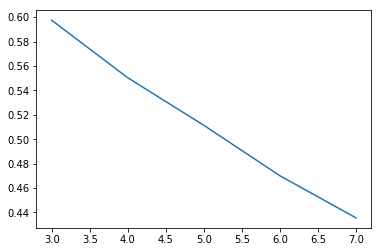

In [212]:
runner = andfmean2
err = []
for k in range(3,8):
    kmmodel = KMeans(n_clusters = k, random_state = 0 ).fit(runner)
    err.append(kmmodel.inertia_)
print(err)
mpl.plot(range(3,8),err)    


In [213]:
k=4
kmmodel = KMeans(n_clusters = k, random_state = 0 ).fit(runner)
print("Error: " + str(kmmodel.inertia_))

Error: 0.5503235995862803


In [214]:
labels = kmmodel.labels_
finaldf=rankedf.drop('Median Home Value',1)
rankedf.head()
finaldf.insert(0,'Cluster',labels)
finaldf.head()
finaldf = finaldf.join(zdf2.set_index('Neighborhood'),on='Neighborhood')
finaldf

,Cluster,Neighborhood,First,Second,Third,Fourth,Fifth,Median Home Value,Latitude,Longitude
0,3,Brooklyn Centre,Zoo Exhibit,Sandwich Place,Pharmacy,Pizza Place,Dive Bar,45000,41.455409,-81.700073
1,0,Buckeye Shaker,Discount Store,Light Rail Station,Bank,Sandwich Place,American Restaurant,68100,41.482862,-81.593843
2,2,Central,Sandwich Place,Pizza Place,Grocery Store,Fast Food Restaurant,Gas Station,97700,41.493157,-81.657598
3,2,Clark Fulton,Sandwich Place,Brewery,Pizza Place,Pharmacy,Park,41100,41.468027,-81.706737
4,0,Corlett,Sandwich Place,Pharmacy,Gas Station,Fast Food Restaurant,Discount Store,41700,41.445973,-81.587938
5,2,Cudell,Pizza Place,Sandwich Place,Pharmacy,Mexican Restaurant,Grocery Store,47000,41.471245,-81.755378
6,2,Detroit Shoreway,Bar,Sandwich Place,Pizza Place,Food Truck,Diner,64400,41.482508,-81.734843
7,2,Downtown,Coffee Shop,Hotel,Theater,American Restaurant,Steakhouse,84900,41.510191,-81.686273
8,2,Edgewater,Diner,Sandwich Place,Mexican Restaurant,Pharmacy,Grocery Store,103500,41.483782,-81.756003
9,2,Euclid Green,Sandwich Place,Grocery Store,Gas Station,Discount Store,Wings Joint,46800,41.553378,-81.550475


An initial exploration of distribution of median home values after clustering by venues.

In [215]:
finaldf.groupby('Cluster').mean()

,Median Home Value,Latitude,Longitude
Cluster,,,
0,48140.000000,41.467941,-81.643835
1,41766.666667,41.483967,-81.608336
2,69606.250000,41.493168,-81.692825
3,49466.666667,41.450117,-81.709812


## Visualization of Clusters

In [216]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [217]:
# create map
map_clusters = folium.Map(location=clell, zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finaldf['Latitude'], finaldf['Longitude'], finaldf['Neighborhood'], finaldf['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Final analysis of clusters

The clusters are split into individual dataframes to be examined.  Also, a value range of one standard deviation above and below the mean to help identify any correlation between cluster and median home value.

In [218]:
valuerange=[]
def find_value_range(m,s):
    b = str(m-s)
    t=str(m+s)
    out = b + " - " + t
    print(out, m,s)
    return out
for n in range(k):
    m=int(finaldf[finaldf['Cluster']==n]['Median Home Value'].mean())
    try:
        s=int(finaldf[finaldf['Cluster']==n]['Median Home Value'].std())        
    except:
        s=0
    valuerange.append(find_value_range(m,s))

38404 - 57876 48140 9736
39209 - 44323 41766 2557
48309 - 90903 69606 21297
33491 - 65441 49466 15975


In [219]:
n=0
print(valuerange[n])
a=finaldf[finaldf['Cluster']==n]
print(a.shape)
a

38404 - 57876
(10, 10)


,Cluster,Neighborhood,First,Second,Third,Fourth,Fifth,Median Home Value,Latitude,Longitude
1,0,Buckeye Shaker,Discount Store,Light Rail Station,Bank,Sandwich Place,American Restaurant,68100,41.482862,-81.593843
4,0,Corlett,Sandwich Place,Pharmacy,Gas Station,Fast Food Restaurant,Discount Store,41700,41.445973,-81.587938
11,0,Forest Hills,Fast Food Restaurant,Grocery Store,Discount Store,BBQ Joint,Sandwich Place,40200,41.539191,-81.599739
16,0,Kinsman,Light Rail Station,Fast Food Restaurant,Discount Store,Restaurant,Pizza Place,43300,41.474573,-81.633190
17,0,Lee Miles,Fast Food Restaurant,Seafood Restaurant,Pharmacy,Gas Station,Discount Store,56800,41.440951,-81.563463
19,0,North Broadway,Fast Food Restaurant,Sandwich Place,Pizza Place,Light Rail Station,Intersection,36600,41.472583,-81.649328
23,0,Puritas-Longmead,Pharmacy,Discount Store,Convenience Store,Sandwich Place,Rental Car Location,53300,41.431929,-81.799845
25,0,South Broadway,Sandwich Place,Pharmacy,Discount Store,Grocery Store,Fast Food Restaurant,41500,41.451918,-81.649576
30,0,West Boulevard,Discount Store,Department Store,Pizza Place,Sandwich Place,Pharmacy,54500,41.458629,-81.749600
31,0,Woodland Hills,Discount Store,Bank,Sandwich Place,Pharmacy,American Restaurant,45400,41.480805,-81.611831


In [220]:
n=1
print(valuerange[n])
a=finaldf[finaldf['Cluster']==n]
print(a.shape)
a

39209 - 44323
(3, 10)


,Cluster,Neighborhood,First,Second,Third,Fourth,Fifth,Median Home Value,Latitude,Longitude
12,1,Glenville,Garden,Convenience Store,BBQ Joint,Park,Fast Food Restaurant,44200,41.533296,-81.618464
18,1,Mt Pleasant,Discount Store,Pharmacy,Light Rail Station,Grocery Store,Park,42000,41.462914,-81.590287
29,1,Union Miles Park,Discount Store,Pharmacy,Deli / Bodega,Thrift / Vintage Store,Park,39100,41.455690,-81.616258


In [221]:
n=2
print(valuerange[n])
a= finaldf[finaldf['Cluster']==n]
print(a.shape)
a

48309 - 90903
(16, 10)


,Cluster,Neighborhood,First,Second,Third,Fourth,Fifth,Median Home Value,Latitude,Longitude
2,2,Central,Sandwich Place,Pizza Place,Grocery Store,Fast Food Restaurant,Gas Station,97700,41.493157,-81.657598
3,2,Clark Fulton,Sandwich Place,Brewery,Pizza Place,Pharmacy,Park,41100,41.468027,-81.706737
5,2,Cudell,Pizza Place,Sandwich Place,Pharmacy,Mexican Restaurant,Grocery Store,47000,41.471245,-81.755378
6,2,Detroit Shoreway,Bar,Sandwich Place,Pizza Place,Food Truck,Diner,64400,41.482508,-81.734843
7,2,Downtown,Coffee Shop,Hotel,Theater,American Restaurant,Steakhouse,84900,41.510191,-81.686273
8,2,Edgewater,Diner,Sandwich Place,Mexican Restaurant,Pharmacy,Grocery Store,103500,41.483782,-81.756003
9,2,Euclid Green,Sandwich Place,Grocery Store,Gas Station,Discount Store,Wings Joint,46800,41.553378,-81.550475
10,2,Fairfax,Sandwich Place,Restaurant,Light Rail Station,Hotel,Pharmacy,58200,41.496114,-81.627204
13,2,Hough,Garden,Pharmacy,Hotel,Grocery Store,Fast Food Restaurant,66300,41.513143,-81.633589
14,2,Jefferson,Park,Sandwich Place,Fast Food Restaurant,Video Store,Pizza Place,58700,41.456077,-81.787534


In [222]:
n=3
print(valuerange[n])
finaldf[finaldf['Cluster']==n]

33491 - 65441


,Cluster,Neighborhood,First,Second,Third,Fourth,Fifth,Median Home Value,Latitude,Longitude
0,3,Brooklyn Centre,Zoo Exhibit,Sandwich Place,Pharmacy,Pizza Place,Dive Bar,45000,41.455409,-81.700073
22,3,Old Brooklyn,Zoo Exhibit,Bar,Sandwich Place,Diner,Convenience Store,67200,41.434653,-81.699439
27,3,Stockyards,Zoo Exhibit,Convenience Store,Sandwich Place,Dive Bar,Discount Store,36200,41.460289,-81.729924


In [223]:
n=4
print(valuerange[n])
finaldf[finaldf['Cluster']==n]

IndexError: list index out of range

## Secondary Analysis

Another approach is to use multiple linear regression.  If the target is median home values, then the input data would be the sum of each venue category for each neighborhood.  We split into train and test sets to evaluate the model.

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

andfy = zdf2['Median Home Value']
andfx = andfsum.drop('Neighborhood',1)

#andfx = andfx.drop('Median Home Values',1)

regr = linear_model.LinearRegression()
x = np.asanyarray(andfx)
y = np.asanyarray(andfy)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=.3)

regr.fit (xtrain, ytrain)


The model seems to fail

In [ ]:
regr.score(xtest,ytest)

In [ ]:
l =[]
for n in range(20):
    regr = linear_model.LinearRegression()
    x = np.asanyarray(andfx)
    y = np.asanyarray(andfy)
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=.3)

    regr.fit (xtrain, ytrain)
    l.append(regr.score(xtest,ytest))
l=np.asanyarray(l)
l.mean()